In [3]:
import kagglehub
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [4]:
kaggle_download_path = kagglehub.dataset_download("google/tinyquickdraw")
print("Downloaded path:", kaggle_download_path)

Downloaded path: C:\Users\gabri\.cache\kagglehub\datasets\google\tinyquickdraw\versions\3


In [5]:
downloaded_files = os.listdir(kaggle_download_path)
print("Downloaded files:", downloaded_files)

Downloaded files: ['baseball bat.ndjson', 'finger.ndjson', 'helmet.ndjson', 'hexagon.ndjson', 'hockey stick.ndjson', 'quickdraw_simplified', 'sketches']


In [6]:
# Defining dataset paths
ndjson_path = kaggle_download_path  # The directory containing .ndjson files
output_path = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset"  

In [7]:
# Creating output directories
os.makedirs(output_path, exist_ok=True)
train_path = os.path.join(output_path, "train")
valid_path = os.path.join(output_path, "valid")

os.makedirs(train_path, exist_ok=True)
os.makedirs(valid_path, exist_ok=True)

In [8]:
# Function to draw strokes and save as PNG
def draw_doodle(strokes, filename, save_path, img_size=256):
    img = np.ones((img_size, img_size), dtype=np.uint8) * 255  # White background
    for stroke in strokes:
        for i in range(len(stroke[0]) - 1):
            cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]), 0, 2)
    
    # Resizing for YOLO
    img = cv2.resize(img, (64, 64)) 
    cv2.imwrite(os.path.join(save_path, filename), img)

In [9]:
# Processing each .ndjson file
for file in tqdm(os.listdir(ndjson_path)):
    if file.endswith(".ndjson"):
        label = file.replace(".ndjson", "")  # Using filename as class label
        label_path = os.path.join(train_path, label)
        os.makedirs(label_path, exist_ok=True)

        with open(os.path.join(ndjson_path, file), "r") as f:
            drawings = [json.loads(line) for line in f]

        # Saving first 80% to train, last 20% to validation
        num_train = int(len(drawings) * 0.8)
        
        for i, drawing in enumerate(drawings):
            filename = f"{label}_{i}.png"
            save_dir = train_path if i < num_train else valid_path
            save_label_path = os.path.join(save_dir, label)
            os.makedirs(save_label_path, exist_ok=True)
            draw_doodle(drawing["drawing"], filename, save_label_path)

print("NDJSON to PNG conversion completed!")

100%|██████████| 7/7 [04:57<00:00, 42.51s/it]

NDJSON to PNG conversion completed!


Checking a sample image:

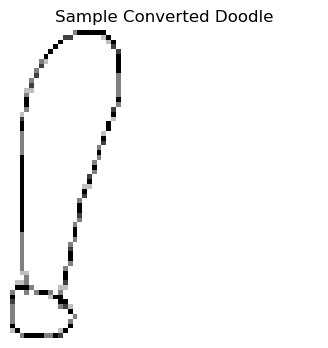

In [10]:
sample_image_path = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train/baseball bat/baseball bat_0.png"

# Load the image
img = cv2.imread(sample_image_path)
if img is None:
    print("Error: Could not load image at", sample_image_path)
else:
    # Convert image from BGR to RGB (OpenCV loads in BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title("Sample Converted Doodle")
    plt.axis("off")
    plt.show()

Defining YOLO Dataset config:

In [12]:
import glob

# YOLO annotation format: <class_id> <x_center> <y_center> <width> <height>
def create_yolo_labels(image_folder, label_folder, class_mapping):
    os.makedirs(label_folder, exist_ok=True)
    images = glob.glob(os.path.join(image_folder, "*/*.png"))

    for img_path in tqdm(images):
        img_name = os.path.basename(img_path)
        class_name = os.path.basename(os.path.dirname(img_path))
        class_id = class_mapping[class_name]

        label_path = os.path.join(label_folder, img_name.replace(".png", ".txt"))
        with open(label_path, "w") as f:
            f.write(f"{class_id} 0.5 0.5 1 1\n")  # Bounding box: whole image

# Creating class mapping
class_names = sorted([f.replace(".ndjson", "") for f in os.listdir(ndjson_path) if f.endswith(".ndjson")])
class_mapping = {name: i for i, name in enumerate(class_names)}

# Generating labels
create_yolo_labels(train_path, os.path.join(output_path, "train_labels"), class_mapping)
create_yolo_labels(valid_path, os.path.join(output_path, "valid_labels"), class_mapping)

print("YOLO annotations created successfully!")

100%|██████████| 137243/137243 [00:23<00:00, 5965.26it/s]

YOLO annotations created successfully!


In [13]:
data_yaml = f"""train: {output_path}/train
val: {output_path}/valid

nc: {len(class_names)}  # Number of classes
names: {class_names}
"""

# Saving data.yaml
with open("data.yaml", "w") as f:
    f.write(data_yaml)

print("Dataset configuration saved as data.yaml")



Dataset configuration saved as data.yaml


In [15]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Ultralytics Version:", ultralytics.__version__)

CUDA Available: True
Ultralytics Version: 8.3.60


In [16]:
train_path = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train"
print("Train folder contents:", os.listdir(train_path))


Train folder contents: ['baseball bat', 'baseball bat.cache', 'finger', 'helmet', 'hexagon', 'hockey stick']


In [17]:
import shutil

# Define the original training directory (with subdirectories)
original_train_dir = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train"
# Define the new flattened directory for images
flat_train_dir = os.path.join(original_train_dir, "images")
os.makedirs(flat_train_dir, exist_ok=True)

# Walk through the original training directory and copy .png files to the flattened directory
for root, dirs, files in os.walk(original_train_dir):
    # Skip the flat_train_dir itself to avoid copying files repeatedly
    if root == flat_train_dir:
        continue
    for file in files:
        if file.endswith(".png"):
            source_file = os.path.join(root, file)
            destination_file = os.path.join(flat_train_dir, file)
            shutil.copy(source_file, destination_file)

print("Flattening complete. All images are in:", flat_train_dir)


Flattening complete. All images are in: C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train\images


In [20]:
# Define the original validation directory (with subdirectories)
original_valid_dir = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid"
# Define the new flattened directory for images in validation
flat_valid_dir = os.path.join(original_valid_dir, "images")
os.makedirs(flat_valid_dir, exist_ok=True)

# Walk through the original validation directory and copy .png files to the flattened directory
for root, dirs, files in os.walk(original_valid_dir):
    # Skip the flat_valid_dir itself to avoid copying files repeatedly
    if root == flat_valid_dir:
        continue
    for file in files:
        if file.endswith(".png"):
            source_file = os.path.join(root, file)
            destination_file = os.path.join(flat_valid_dir, file)
            shutil.copy(source_file, destination_file)

print("Flattening complete. All validation images are in:", flat_valid_dir)

Flattening complete. All validation images are in: C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid\images


In [21]:
data_yaml = f"""train: "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train/images"
val: "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid/images"

nc: 10  # Number of classes
names: ['alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'arm', 'asparagus', 'bandage', 'baseball']
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

print("Dataset configuration saved as data.yaml")

Dataset configuration saved as data.yaml


In [23]:
train_images_dir = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train/images"
valid_images_dir = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid/images"

print("Train images count:", len([f for f in os.listdir(train_images_dir) if f.endswith('.png')]))
print("Valid images count:", len([f for f in os.listdir(valid_images_dir) if f.endswith('.png')]))

Train images count: 548967
Valid images count: 137243


In [ ]:
output_path = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset"

# Moving train labels to train/labels
original_train_labels = os.path.join(output_path, "train_labels")
destination_train_labels = os.path.join(output_path, "train", "labels")
if os.path.exists(original_train_labels):
    # If the destination folder already exists, you might want to remove it or merge the files
    shutil.move(original_train_labels, destination_train_labels)
    print("Train labels moved to:", destination_train_labels)
else:
    print("No train_labels folder found.")

# Moving validation labels to valid/labels
original_valid_labels = os.path.join(output_path, "valid_labels")
destination_valid_labels = os.path.join(output_path, "valid", "labels")
if os.path.exists(original_valid_labels):
    shutil.move(original_valid_labels, destination_valid_labels)
    print("Valid labels moved to:", destination_valid_labels)
else:
    print("No valid_labels folder found.")

Train labels moved to: C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset\train\labels
Valid labels moved to: C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset\valid\labels


In [26]:
train_images = os.listdir("C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train/images")
train_labels = os.listdir("C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/train/labels")
valid_images = os.listdir("C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid/images")
valid_labels = os.listdir("C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid/labels")

print("Train images count:", len(train_images))
print("Train labels count:", len(train_labels))
print("Valid images count:", len(valid_images))
print("Valid labels count:", len(valid_labels))

Train images count: 548967
Train labels count: 548967
Valid images count: 137243
Valid labels count: 137243


In [27]:
# Loading the YOLOv8 nano model
model = YOLO("yolov8n.pt")

# Training the model 
model.train(
    data="data.yaml",    # dataset configuration file
    epochs=10,           
    imgsz=128,           
    batch=8,             
    device="cuda",       
    workers=0           # Using 0 workers to avoid multiprocessing issues on Windows
)


New https://pypi.org/project/ultralytics/8.3.94 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.60  Python-3.10.14 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=128, save=True, save_period=-1, cache=False, device=cuda, workers=0, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\MSAAI\AAI-590\Data\tinyquickdraw_dataset\train\labels... 548967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 548967/548967 [02:58<00:00, 3079.39it/s]


train: New cache created: C:\MSAAI\AAI-590\Data\tinyquickdraw_dataset\train\labels.cache


val: Scanning C:\MSAAI\AAI-590\Data\tinyquickdraw_dataset\valid\labels... 137243 images, 0 backgrounds, 0 corrupt: 100%|██████████| 137243/137243 [00:44<00:00, 3102.86it/s]


val: New cache created: C:\MSAAI\AAI-590\Data\tinyquickdraw_dataset\valid\labels.cache
Plotting labels to c:\Users\gabri\runs\detect\train17\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to c:\Users\gabri\runs\detect\train17
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.218G    0.09283     0.5231      0.915          7        128: 100%|██████████| 68621/68621 [1:21:58<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [10:34<00:00, 13.52it/s]


                   all     137243     137243      0.976      0.929      0.974      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.631G    0.07304     0.2858     0.9055          7        128: 100%|██████████| 68621/68621 [1:16:47<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [09:30<00:00, 15.04it/s]


                   all     137243     137243      0.977      0.873      0.956      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.554G    0.06581     0.2653     0.9038          7        128: 100%|██████████| 68621/68621 [1:09:31<00:00, 16.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [09:34<00:00, 14.92it/s]


                   all     137243     137243      0.889      0.825      0.937      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.558G    0.05608     0.2439     0.9017          7        128: 100%|██████████| 68621/68621 [1:09:03<00:00, 16.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [09:45<00:00, 14.66it/s]


                   all     137243     137243      0.873      0.813      0.925      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.556G    0.04715     0.2227     0.9014          7        128: 100%|██████████| 68621/68621 [1:11:57<00:00, 15.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [10:01<00:00, 14.27it/s]


                   all     137243     137243      0.942      0.801      0.925      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.505G    0.04186      0.208     0.9004          7        128: 100%|██████████| 68621/68621 [1:13:05<00:00, 15.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [09:41<00:00, 14.74it/s]


                   all     137243     137243      0.823      0.861      0.941      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.487G    0.03691     0.1956     0.9004          7        128: 100%|██████████| 68621/68621 [1:06:50<00:00, 17.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [08:51<00:00, 16.13it/s]


                   all     137243     137243      0.774      0.896      0.946      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.487G        inf     0.1826     0.8992          7        128: 100%|██████████| 68621/68621 [1:02:18<00:00, 18.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [08:50<00:00, 16.17it/s]


                   all     137243     137243      0.757      0.907      0.947      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.487G        inf     0.1691     0.8987          7        128: 100%|██████████| 68621/68621 [1:02:11<00:00, 18.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [08:51<00:00, 16.15it/s]


                   all     137243     137243      0.758      0.912       0.95      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.484G        inf     0.1544     0.8989          7        128: 100%|██████████| 68621/68621 [1:02:22<00:00, 18.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [08:53<00:00, 16.09it/s]


                   all     137243     137243      0.767      0.914      0.954      0.944

10 epochs completed in 13.190 hours.
Optimizer stripped from c:\Users\gabri\runs\detect\train17\weights\last.pt, 6.2MB
Optimizer stripped from c:\Users\gabri\runs\detect\train17\weights\best.pt, 6.2MB

Validating c:\Users\gabri\runs\detect\train17\weights\best.pt...
Ultralytics 8.3.60  Python-3.10.14 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8578/8578 [08:28<00:00, 16.88it/s]


                   all     137243     137243      0.976      0.929      0.974      0.972
           alarm clock      24762      24762      0.979       0.87      0.962      0.959
             ambulance      33592      33592      0.981      0.915      0.964      0.962
                 angel      24380      24380      0.972      0.959      0.983      0.981
      animal migration      28487      28487       0.99       0.95      0.988      0.988
                   ant      26022      26022      0.958      0.952      0.976      0.972
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to c:\Users\gabri\runs\detect\train17


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002416DA58C70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

In [ ]:
# Loading the trained model using the best checkpoint
model = YOLO("c:/Users/gabri/runs/detect/train17/weights/best.pt")

In [33]:
valid_images_dir = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid/images"
files = os.listdir(valid_images_dir)
print("Validation images available:", files)

Validation images available: ['baseball bat_100000.png', 'baseball bat_100001.png', 'baseball bat_100002.png', 'baseball bat_100003.png', 'baseball bat_100004.png', 'baseball bat_100005.png', 'baseball bat_100006.png', 'baseball bat_100007.png', 'baseball bat_100008.png', 'baseball bat_100009.png', 'baseball bat_100010.png', 'baseball bat_100011.png', 'baseball bat_100012.png', 'baseball bat_100013.png', 'baseball bat_100014.png', 'baseball bat_100015.png', 'baseball bat_100016.png', 'baseball bat_100017.png', 'baseball bat_100018.png', 'baseball bat_100019.png', 'baseball bat_100020.png', 'baseball bat_100021.png', 'baseball bat_100022.png', 'baseball bat_100023.png', 'baseball bat_100024.png', 'baseball bat_100025.png', 'baseball bat_100026.png', 'baseball bat_100027.png', 'baseball bat_100028.png', 'baseball bat_100029.png', 'baseball bat_100030.png', 'baseball bat_100031.png', 'baseball bat_100032.png', 'baseball bat_100033.png', 'baseball bat_100034.png', 'baseball bat_100035.png'

In [34]:
# Defining a test image path
test_image_path = "C:/MSAAI/AAI-590/Data/tinyquickdraw_dataset/valid/images/baseball bat_100088.png"


image 1/1 C:\MSAAI\AAI-590\Data\tinyquickdraw_dataset\valid\images\baseball bat_100088.png: 128x128 1 alarm clock, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 6.0ms postprocess per image at shape (1, 3, 128, 128)


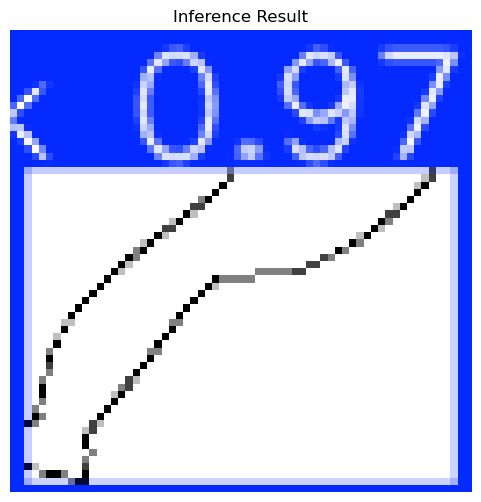

In [35]:
# Running inference
results = model(test_image_path)

# Displaying the image with bounding boxes
img_with_boxes = results[0].plot()  # This returns the image with drawn predictions
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Inference Result")
plt.axis("off")
plt.show()